In [ ]:
import os
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import pandas as pd


In [ ]:
!unzip /content/train1.csv..zip

Archive:  /content/train1.csv..zip
  inflating: train.csv               


In [ ]:
train = pd.read_csv('/content/train.csv')

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )
class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df,tokenizer,max_length):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"full_text"]
        tokens = self.tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=self.max,
                return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

In [ ]:

def get_embeddings(model_name, max_length, batch_size, compute_train=True):
    global train  # Assuming 'train' is your global train dataset
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"Loading model and tokenizer for {model_name}")
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    ds_tr = EmbedDataset(train, tokenizer, max_length)
    embed_dataloader_tr = torch.utils.data.DataLoader(ds_tr, batch_size=batch_size, shuffle=False)

    model = model.to(DEVICE)
    model.eval()

    all_train_text_feats = []
    if compute_train:
        for batch in tqdm(embed_dataloader_tr, total=len(embed_dataloader_tr), desc=f"Computing embeddings for {model_name}"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            with torch.no_grad():
                with torch.cuda.amp.autocast(enabled=True):
                    model_output = model(input_ids=input_ids, attention_mask=attention_mask)
            sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
            sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)
            sentence_embeddings = sentence_embeddings.detach().cpu().numpy()
            all_train_text_feats.extend(sentence_embeddings)

    all_train_text_feats = np.array(all_train_text_feats)

    del model, tokenizer, ds_tr, embed_dataloader_tr
    torch.cuda.empty_cache()

    return all_train_text_feats

models = [
    ('allenai/longformer-base-4096', 1024, 32),
    ('allenai/led-base-16384', 1024, 32),
    ('allenai/led-large-16384', 1024, 8),
    ("facebook/bart-large", 1024, 8),
    ('allenai/longformer-large-4096', 1024, 8),
]

output_path = "/content/CalcEmb/"
os.makedirs(output_path, exist_ok=True)

In [ ]:
for model_name, max_length, batch_size in models:
    output_file = os.path.join(output_path, f"{model_name.replace('/', '_')}_embeddings.npy")

    if os.path.exists(output_file):
        print(f"Embeddings for {model_name} already computed. Skipping.")
        continue

    print(f"Computing embeddings for {model_name}")
    embeddings = get_embeddings(model_name, max_length, batch_size)

    print(f"Saving embeddings for {model_name}")
    np.save(output_file, embeddings)

    print(f"Embeddings shape for {model_name}: {embeddings.shape}")
    print(f"Embeddings saved to {output_file}")
    print("-" * 50)

    # Load the embeddings from the saved file
    loaded_embeddings = np.load(output_file)

    # Concatenate the loaded embeddings with themselves along axis 1
    concatenated_embeddings = np.concatenate((loaded_embeddings, loaded_embeddings), axis=1)

    # Print the shape of the concatenated embeddings
    print(f"Shape of concatenated embeddings for {model_name}: {concatenated_embeddings.shape}")
    print("=" * 50)

print("All embeddings computed, saved, and concatenated.")


Computing embeddings for allenai/longformer-base-4096
Loading model and tokenizer for allenai/longformer-base-4096


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Computing embeddings for allenai/longformer-base-4096: 100%|██████████| 541/541 [10:49<00:00,  1.20s/it]


Saving embeddings for allenai/longformer-base-4096
Embeddings shape for allenai/longformer-base-4096: (17307, 768)
Embeddings saved to /content/CalcEmb/allenai_longformer-base-4096_embeddings.npy
--------------------------------------------------
Shape of concatenated embeddings for allenai/longformer-base-4096: (17307, 1536)
Computing embeddings for allenai/led-base-16384
Loading model and tokenizer for allenai/led-base-16384


Computing embeddings for allenai/led-base-16384: 100%|██████████| 541/541 [15:14<00:00,  1.69s/it]


Saving embeddings for allenai/led-base-16384
Embeddings shape for allenai/led-base-16384: (17307, 768)
Embeddings saved to /content/CalcEmb/allenai_led-base-16384_embeddings.npy
--------------------------------------------------
Shape of concatenated embeddings for allenai/led-base-16384: (17307, 1536)
Computing embeddings for allenai/led-large-16384
Loading model and tokenizer for allenai/led-large-16384


Computing embeddings for allenai/led-large-16384: 100%|██████████| 2164/2164 [41:59<00:00,  1.16s/it]


Saving embeddings for allenai/led-large-16384
Embeddings shape for allenai/led-large-16384: (17307, 1024)
Embeddings saved to /content/CalcEmb/allenai_led-large-16384_embeddings.npy
--------------------------------------------------
Shape of concatenated embeddings for allenai/led-large-16384: (17307, 2048)
Computing embeddings for facebook/bart-large
Loading model and tokenizer for facebook/bart-large


Computing embeddings for facebook/bart-large: 100%|██████████| 2164/2164 [10:30<00:00,  3.43it/s]


Saving embeddings for facebook/bart-large
Embeddings shape for facebook/bart-large: (17307, 1024)
Embeddings saved to /content/CalcEmb/facebook_bart-large_embeddings.npy
--------------------------------------------------
Shape of concatenated embeddings for facebook/bart-large: (17307, 2048)
Computing embeddings for allenai/longformer-large-4096
Loading model and tokenizer for allenai/longformer-large-4096


Computing embeddings for allenai/longformer-large-4096: 100%|██████████| 2164/2164 [32:12<00:00,  1.12it/s]

Saving embeddings for allenai/longformer-large-4096
Embeddings shape for allenai/longformer-large-4096: (17307, 1024)
Embeddings saved to /content/CalcEmb/allenai_longformer-large-4096_embeddings.npy
--------------------------------------------------
Shape of concatenated embeddings for allenai/longformer-large-4096: (17307, 2048)
All embeddings computed, saved, and concatenated.


In [ ]:
array1 = np.load('/content/CalcEmb/allenai_longformer-base-4096_embeddings.npy')
array2 = np.load('/content/allenai_longformer-base-4096.npy')

# Check if the arrays are identical
identical = np.array_equal(array1, array2)

if identical:
    print("The arrays are identical.")
else:
    print("The arrays are not identical.")

The arrays are not identical.


In [ ]:
checkone = pd.DataFrame(array1)
checktwo = pd.DataFrame(array2)

In [ ]:
checkone.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.001864,0.005534,0.004011,-0.004042,-0.004125,0.009843,0.001537,0.004661,0.000428,-0.004049,...,0.000932,-0.003449,-0.003657,0.002835,-0.001159,0.004163,0.013982,-0.005370,0.003095,-0.000718
1,-0.002223,0.001095,0.004353,-0.008577,0.004567,0.011797,-0.000857,0.010792,0.002283,-0.000937,...,-0.003673,-0.000185,-0.000521,0.003219,-0.002020,0.006651,0.016553,-0.014474,-0.000156,0.000037
2,-0.000247,0.010436,0.008977,-0.011219,-0.006926,0.027528,0.003124,0.005621,-0.001977,-0.010039,...,-0.001910,-0.001946,0.006713,0.000624,0.009331,0.006313,0.001716,-0.001725,0.000168,0.000810
3,0.001337,0.005203,0.007038,-0.009568,0.005141,0.011754,0.001182,0.007402,0.004282,-0.000513,...,-0.002940,-0.004035,0.009832,-0.002665,0.007640,0.008468,-0.000681,0.001037,0.005702,0.000008
4,0.003102,0.006746,0.010628,-0.000118,0.010138,0.007542,-0.001666,0.014467,0.001383,-0.002721,...,0.001280,-0.005886,-0.003588,-0.001274,0.009039,0.006293,0.010097,0.012182,-0.000493,0.004454


In [ ]:
checktwo.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.001866,0.005535,0.004006,-0.004040,-0.004121,0.009836,0.001536,0.004660,0.000432,-0.004049,...,0.000936,-0.003452,-0.003660,0.002837,-0.001160,0.004161,0.013983,-0.005373,0.003093,-0.000714
1,-0.002226,0.001098,0.004355,-0.008581,0.004567,0.011803,-0.000852,0.010786,0.002281,-0.000932,...,-0.003675,-0.000189,-0.000524,0.003218,-0.002019,0.006654,0.016548,-0.014468,-0.000154,0.000041
2,-0.000244,0.010434,0.008977,-0.011217,-0.006925,0.027518,0.003121,0.005617,-0.001978,-0.010038,...,-0.001907,-0.001944,0.006719,0.000624,0.009331,0.006312,0.001715,-0.001728,0.000170,0.000809
3,0.001338,0.005202,0.007039,-0.009568,0.005145,0.011755,0.001181,0.007407,0.004283,-0.000517,...,-0.002943,-0.004033,0.009832,-0.002664,0.007640,0.008470,-0.000681,0.001038,0.005700,0.000016
4,0.003102,0.006749,0.010627,-0.000124,0.010143,0.007542,-0.001665,0.014468,0.001383,-0.002726,...,0.001277,-0.005887,-0.003591,-0.001278,0.009046,0.006297,0.010099,0.012192,-0.000496,0.004455


DataFrame 1 Statistics:
                0             1             2             3             4    \
count  17307.000000  17307.000000  17307.000000  17307.000000  17307.000000   
mean       0.000397      0.006313      0.005969     -0.006750     -0.002063   
std        0.002727      0.004439      0.002350      0.004400      0.010675   
min       -0.025260     -0.022065     -0.011930     -0.026063     -0.049581   
25%       -0.001176      0.003545      0.004517     -0.009635     -0.009468   
50%        0.000642      0.006586      0.005994     -0.007039     -0.002272   
75%        0.002197      0.009509      0.007466     -0.004216      0.004846   
max        0.009771      0.019048      0.014981      0.033621      0.041178   

                5             6             7             8             9    \
count  17307.000000  17307.000000  17307.000000  17307.000000  17307.000000   
mean       0.016758      0.001434      0.006244      0.003274     -0.003452   
std        0.006755      0.

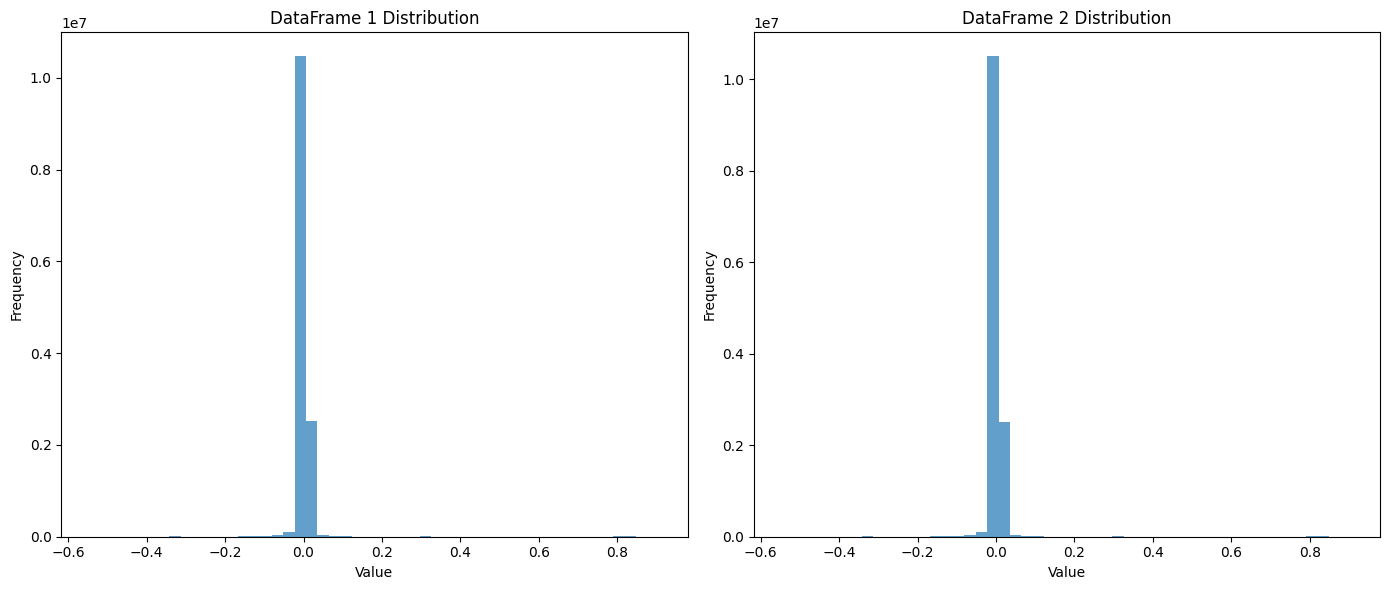

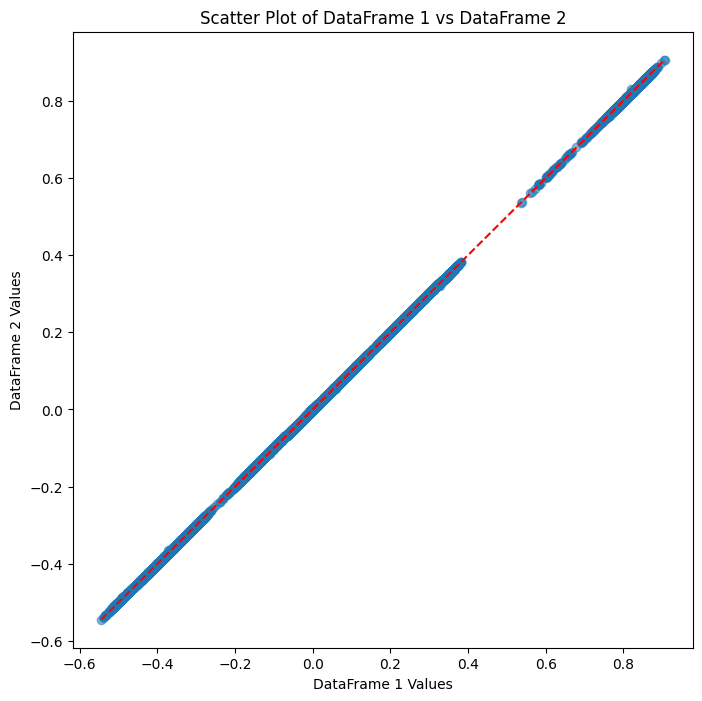

In [ ]:
import matplotlib.pyplot as plt
print("DataFrame 1 Statistics:")
print(checkone.describe())
print("\nDataFrame 2 Statistics:")
print(checktwo.describe())

# Plot histograms for comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(checkone.values.flatten(), bins=50, alpha=0.7, label='DataFrame 1')
plt.title('DataFrame 1 Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(checktwo.values.flatten(), bins=50, alpha=0.7, label='DataFrame 2')
plt.title('DataFrame 2 Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot for direct comparison
plt.figure(figsize=(8, 8))
plt.scatter(checkone.values.flatten(), checktwo.values.flatten(), alpha=0.5)
plt.title('Scatter Plot of DataFrame 1 vs DataFrame 2')
plt.xlabel('DataFrame 1 Values')
plt.ylabel('DataFrame 2 Values')
plt.plot([checkone.values.min(), checkone.values.max()], [checkone.values.min(), checkone.values.max()], 'r--')
plt.show()

In [ ]:
from google.colab import files
files.download('/content/CalcEmb.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/CalcEmb.zip /content/CalcEmb

  adding: content/CalcEmb/ (stored 0%)
  adding: content/CalcEmb/facebook_bart-large_embeddings.npy (deflated 7%)
  adding: content/CalcEmb/allenai_longformer-base-4096_embeddings.npy (deflated 7%)
  adding: content/CalcEmb/allenai_led-base-16384_embeddings.npy (deflated 7%)
  adding: content/CalcEmb/allenai_led-large-16384_embeddings.npy (deflated 7%)
  adding: content/CalcEmb/allenai_longformer-large-4096_embeddings.npy (deflated 7%)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import shutil
shutil.copy("file_path","/content/drive/MyDrive/folder_name")